In [2]:
import pandas as pd
import numpy as np
from typing import Optional, List, Callable, Any, Union, Dict
from itertools import product
from statistics import mean
from pathlib import Path
import gzip
import os
import matplotlib.pyplot as plt

### Read datasets
Use the gzip function is files ar gzipped

In [3]:
def read_ds_gzip(path: Optional[Path]=None, ds: str = "TRAIN") -> pd.DataFrame:
    """Args:
        path (Optional[Path], optional): the path to read the dataset file. Defaults to /kaggle/input/the-insa-starcraft-2-player-prediction-challenge/{ds}.CSV.gz.
        ds (str, optional): the part to read (TRAIN or TEST), to use when path is None. Defaults to "TRAIN".

    Returns:
        pd.DataFrame:
    """
    with gzip.open(f'/kaggle/input/the-insa-starcraft-2-player-prediction-challenge/{ds}.CSV.gz' if path is None else path) as f:
        max_actions = max(( len( str(c).split(",")) for c in f.readlines() ))
        f.seek(0)
        _names = ["battleneturl", "played_race"] if "TRAIN" in ds else ["played_race"]
        _names.extend(range(max_actions - len(_names)))
        return pd.read_csv(f, names=_names, dtype= str)

def read_ds(path: Optional[Path]=None, ds: str = "TRAIN"):
    """Args:
        path (Optional[Path], optional): the path to read the dataset file. Defaults to /kaggle/input/the-insa-starcraft-2-player-prediction-challenge/{ds}.CSV.gz.
        ds (str, optional): the part to read (TRAIN or TEST), to use when path is None. Defaults to "TRAIN".

    Returns:
        pd.DataFrame:
    """
    with open(f'/kaggle/input/train-sc2-keystrokes/{ds}.CSV' if path is None else path) as f:
        max_actions = max(( len( str(c).split(",")) for c in f.readlines() ))
        f.seek(0)
        _names = ["battleneturl", "played_race"] if "TRAIN" in ds else ["played_race"]
        _names.extend(range(max_actions - len(_names)))
        return pd.read_csv(f, names=_names, dtype= str)

In [4]:
features_train = read_ds_gzip(Path("data/TRAIN.CSV.GZ")) # Replace with correct path 

# features_test = read_ds("TEST")
features_train.shape #, features_test.shape

(3052, 10539)

In [5]:
features_train.head()

,battleneturl,played_race,0,1,2,3,4,5,6,7,...,10527,10528,10529,10530,10531,10532,10533,10534,10535,10536
0,http://eu.battle.net/sc2/en/profile/4234852/1/...,Protoss,Base,s,s,s,s,s,t5,Base,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,http://eu.battle.net/sc2/en/profile/3074362/1/...,Protoss,s,Base,s,s,Base,s,s,Base,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,http://eu.battle.net/sc2/en/profile/4234852/1/...,Protoss,Base,s,s,s,Base,s,hotkey30,hotkey00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,http://eu.battle.net/sc2/en/profile/3074362/1/...,Protoss,Base,s,s,Base,s,s,s,t5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,http://eu.battle.net/sc2/en/profile/4234852/1/...,Protoss,Base,s,s,s,Base,s,hotkey30,hotkey00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Dependent Variable
Our dependent variable is a categorical string; we can convert it to categories codes (number) with pd.Categorical

pd.Categorical doesn't directly modify the battleneturl to a number, instead it adds a cat.codes attribute to it. We can create a little function to convert the dependent variable from string to its category ID:

In [6]:
def to_categories(df: pd.DataFrame, col: str="battleneturl") -> None:
    """Convert col of df to a categorical column"""
    df["battleneturl"] = pd.Categorical(df["battleneturl"])
    df[[col]] = df[[col]].apply(lambda x: x.cat.codes)

#### Removing outliers
YOUR IDEAS / APPROACHES HERE.



In [7]:
to_categories(features_train)

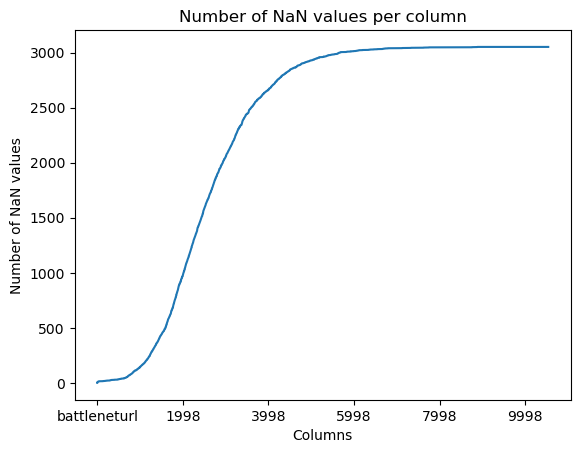

In [8]:
import matplotlib.pyplot as plt

nan_counts = features_train.isna().sum()
nan_counts.plot()
plt.xlabel('Columns')
plt.ylabel('Number of NaN values')
plt.title('Number of NaN values per column')
plt.show()

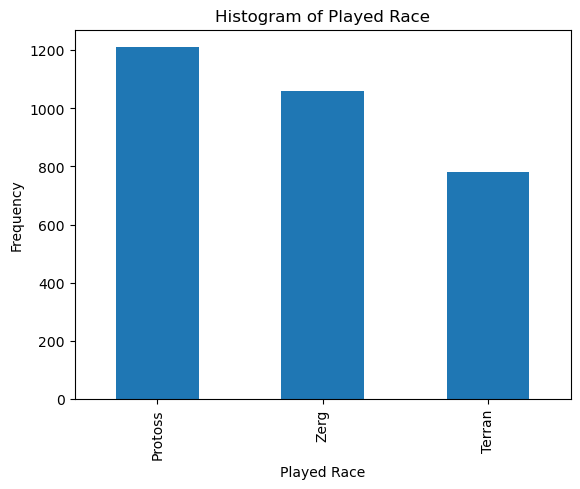

In [9]:
features_train['played_race'].value_counts().plot(kind='bar')
plt.xlabel('Played Race')
plt.ylabel('Frequency')
plt.title('Histogram of Played Race')
plt.show()

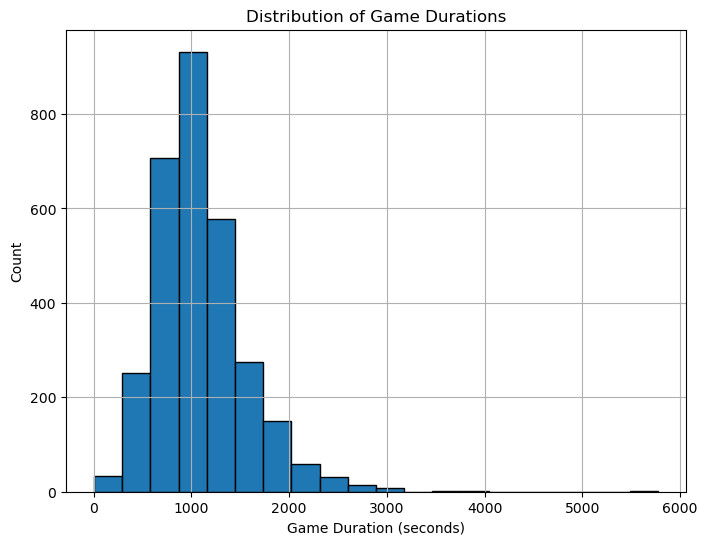

In [10]:

durations = []

# Iterate over each row in the dataframe
for _, row in features_train.iterrows():
    # Convert the row to a list (strings, possibly some NaN if missing)
    row_list = row.tolist()

    # Filter columns that start with "t" (e.g., "t10", "t120", etc.)
    time_tokens = [
        col for col in row_list if isinstance(col, str) and col.startswith("t")
    ]

    if time_tokens:
        # Get the last time token in the row
        last_time_token = time_tokens[-1]
        # Convert from e.g. "t135" -> integer 135
        duration = int(last_time_token[1:])
        durations.append(duration)
    else:
        # If no time tokens, we can append None or skip.
        durations.append(None)

# Store the durations in the dataframe as a new column for convenience
features_train["duration"] = durations

# Drop rows without a valid duration
features_train.dropna(subset=["duration"], inplace=True)

# Plot the distribution as a histogram
plt.figure(figsize=(8, 6))
features_train["duration"].plot(kind="hist", bins=20, edgecolor="black")
plt.title("Distribution of Game Durations")
plt.xlabel("Game Duration (seconds)")
plt.ylabel("Count")
plt.grid(True)
plt.show()


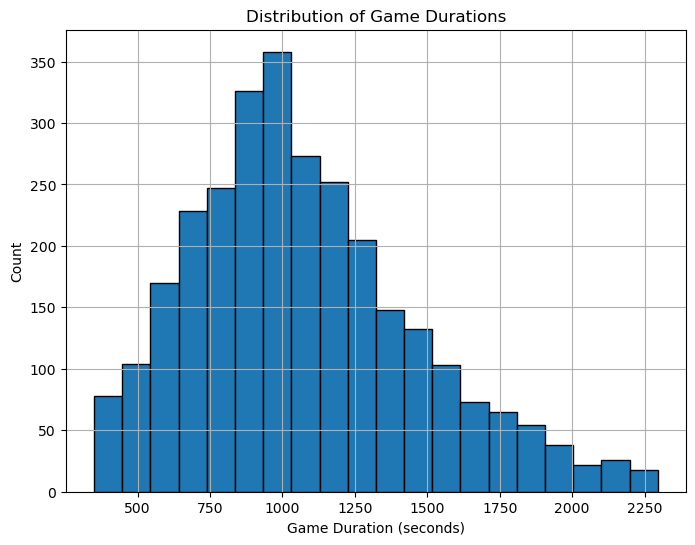

In [11]:
# Keep the central 96% (remove bottom and top 2%)
q02 = features_train['duration'].quantile(0.02)
q98 = features_train['duration'].quantile(0.98)

features_train_filtered = features_train[(features_train['duration'] >= q02) & (features_train['duration'] <= q98)]
    

# Plot the distribution as a histogram
plt.figure(figsize=(8, 6))
features_train_filtered['duration'].plot(kind='hist', bins=20, edgecolor='black')
plt.title('Distribution of Game Durations')
plt.xlabel('Game Duration (seconds)')
plt.ylabel('Count')
plt.grid(True)
plt.show()

In [12]:
import pandas as pd

# Display global statistics about the dataset
print("Total number of rows (games):", len(features_train_filtered))

# If you have a unique player identifier (e.g. 'battleneturl')
if "battleneturl" in features_train_filtered.columns:
    print("Number of unique players:", features_train_filtered["battleneturl"].nunique())

# If you have a race column (e.g. 'played_race')
if "played_race" in features_train_filtered.columns:
    print("Number of unique races:", features_train_filtered["played_race"].nunique(), "\n")
    print("=== Race Distribution ===\n", features_train_filtered["played_race"].value_counts(), "\n")

# Basic statistics for durations
if "duration" in features_train_filtered.columns:
    print("=== Duration Summary ===")
    print(features_train_filtered["duration"].agg(["min", "max", "mean", "std"]))

    # Example: Group by race to see duration stats per race
    if "played_race" in features_train_filtered.columns:
        print("\n=== Duration by Race ===")
        print(features_train_filtered.groupby("played_race")["duration"].agg(["min", "max", "mean", "std"]))


Total number of rows (games): 2920
Number of unique players: 200
Number of unique races: 3 

=== Race Distribution ===
 played_race
Protoss    1169
Zerg        999
Terran      752
Name: count, dtype: int64 

=== Duration Summary ===
min      350.000000
max     2295.000000
mean    1075.256849
std      387.062026
Name: duration, dtype: float64

=== Duration by Race ===
               min     max         mean         std
played_race                                        
Protoss      350.0  2275.0  1040.094098  374.352740
Terran       355.0  2295.0  1141.382979  397.400611
Zerg         350.0  2265.0  1066.626627  387.971682


In [13]:
# drop duration column
features_train_filtered.drop(columns=['duration'], inplace=True)

/tmp/ipykernel_1605362/1201346037.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train_filtered.drop(columns=['duration'], inplace=True)


In [14]:
# Make a deep copy to avoid the SettingWithCopyWarning
features_train_filtered = features_train_filtered.copy()

# Now safely do your assignments
action_cols = features_train_filtered.columns[2:]
features_train_filtered["actions"] = (
    features_train_filtered[action_cols]
    .apply(lambda row: [x for x in row if pd.notna(x)], axis=1)
)

features_train_filtered.drop(columns=action_cols, inplace=True)

### Custom features

In [15]:
def chunkify_actions(action_list):
    """
    Given a list of actions (e.g., ["Base", "s", "s", "t5", "hotkey30", "t10", ...]),
    produce a list of tuples (start_time, end_time, actions_in_chunk).
    If we see 't5', that means the chunk boundary is 5 seconds, etc.
    """
    chunks = []
    current_time = 0
    chunk_actions = []

    def parse_time_marker(a):
        # e.g. 't5' -> int("5")
        return int(a[1:])

    for a in action_list:
        if a.startswith("t"):
            # We hit a time boundary
            end_time = parse_time_marker(a)
            if chunk_actions:
                chunks.append((current_time, end_time, chunk_actions))
            # Move forward
            current_time = end_time
            chunk_actions = []
        else:
            # It's a normal action
            chunk_actions.append(a)

    # If leftover actions exist after the last tXX
    # We'll treat them as from current_time to current_time (0-length),
    # or you can define a “max game time” if known. For now, let's store them anyway.
    if chunk_actions:
        chunks.append((current_time, current_time, chunk_actions))

    return chunks


In [16]:
def compute_features_per_chunk(chunks):
    """
    Given a list of (start_t, end_t, actions_in_chunk),
    classify them into early/mid/late, count relevant actions,
    compute average in each phase.
    """
    # Phase boundaries
    EARLY_MAX = 360  # 6 minutes
    MID_MAX = 720  # 12 minutes

    # We'll accumulate total counts and total durations (in seconds) for each phase
    phases = ["early", "mid", "late"]

    base_keys = {
        "hk_created": 0,
        "hk_updated": 0,
        "hk_used":    0,
        "base":       0,
        "mineral":    0,
        "other":      0
    }

    phase_counts = {
        ph: {
            **{f"hk_{i}": 0 for i in range(10)},
            **base_keys
        }
        for ph in phases
    }

    phase_durations = {ph: 0 for ph in phases}

    def get_phase(t):
        if t < EARLY_MAX:
            return "early"
        elif t < MID_MAX:
            return "mid"
        else:
            return "late"

    for start_t, end_t, acts in chunks:
        # Simple approach: classify chunk by its start time (some people use midpoint)
        phase = get_phase(start_t)
        # Avoid zero durations => set it to at least 1 second
        duration = max(1, end_t - start_t)

        # Count actions in this chunk
        c_hk_pressed = {f"c_hk_{i}": 0 for i in range(10)}
        c_hk_created = 0
        c_hk_updated = 0
        c_hk_used = 0
        c_base = 0
        c_mineral = 0
        c_other = 0

        for a in acts:
            if a.startswith("hotkey"):
                key = int(a[-2])
                c_hk_pressed[f"c_hk_{key}"] += 1
                # check last char if it is "0","1","2"
                if a.endswith("0"):
                    c_hk_created += 1
                elif a.endswith("1"):
                    c_hk_updated += 1
                elif a.endswith("2"):
                    c_hk_used += 1
            elif a in ["sBase", "Base"]:
                c_base += 1
            elif a in ["sMineral", "SingleMineral"]:
                c_mineral += 1
            elif a == "s":
                c_other += 1
            else:
                # some other action not relevant here
                pass

        for i in range(10):
            phase_counts[phase][f"hk_{i}"] += c_hk_pressed[f"c_hk_{i}"]
        phase_counts[phase]["hk_created"] += c_hk_created
        phase_counts[phase]["hk_updated"] += c_hk_updated
        phase_counts[phase]["hk_used"] += c_hk_used
        phase_counts[phase]["base"] += c_base
        phase_counts[phase]["mineral"] += c_mineral
        phase_counts[phase]["other"] += c_other

        phase_durations[phase] += duration

    # Now compute the final average for each phase
    # e.g.  (count / total_duration_in_phase)
    feats = {}
    for phase in ["early", "mid", "late"]:
        dur = phase_durations[phase]
        pc = phase_counts[phase]
        if dur == 0:
            # no data for that phase
            for i in range(10):
                feats[f"{phase}_hotkey_{i}"] = 0
            feats[f"{phase}_hotkey_created"] = 0
            feats[f"{phase}_hotkey_updated"] = 0
            feats[f"{phase}_hotkey_used"] = 0
            feats[f"{phase}_base"] = 0
            feats[f"{phase}_mineral"] = 0
            feats[f"{phase}_other"] = 0
        else:
            for i in range(10):
                feats[f"{phase}_hotkey_{i}"] = (pc[f"hk_{i}"] / dur)
            feats[f"{phase}_hotkey_created"] = (pc["hk_created"] / dur)
            feats[f"{phase}_hotkey_updated"] = (pc["hk_updated"] / dur)
            feats[f"{phase}_hotkey_used"] = (pc["hk_used"] / dur)
            feats[f"{phase}_base"] = (pc["base"] / dur)
            feats[f"{phase}_mineral"] = (pc["mineral"] / dur)
            feats[f"{phase}_other"] = (pc["other"] / dur)

    return feats

In [17]:
def compute_all_features(row):
    """
    row is a single Pandas row with:
       row["actions"] = list of action strings
       row["battleneturl"], row["played_race"], etc. if needed
    Returns a dict of feature_name -> value
    """
    chunks = chunkify_actions(row)
    feats = compute_features_per_chunk(chunks)
    
    # You can also include the player's ID or race in the returned features if desired
    return feats

# Apply to entire DataFrame
features_df = features_train_filtered["actions"].apply(compute_all_features).apply(pd.Series)

print(features_df.head())

# Combine with the original df if you like
result_df = pd.concat([features_train_filtered, features_df], axis=1)
print(result_df.head())


   early_hotkey_0  early_hotkey_1  early_hotkey_2  early_hotkey_3  \
0        0.002985        0.137313        0.059701        0.498507   
1        0.000000        0.211111        0.094444        0.427778   
2        0.002899        0.107246        0.028986        0.550725   
3        0.002778        0.250000        0.061111        0.386111   
4        0.002857        0.091429        0.057143        0.485714   

   early_hotkey_4  early_hotkey_5  early_hotkey_6  early_hotkey_7  \
0        0.176119        0.014925        0.020896        0.002985   
1        0.438889        0.000000        0.000000        0.000000   
2        0.127536        0.037681        0.000000        0.000000   
3        0.416667        0.000000        0.000000        0.000000   
4        0.117143        0.040000        0.000000        0.000000   

   early_hotkey_8  early_hotkey_9  ...  late_hotkey_6  late_hotkey_7  \
0        0.000000             0.0  ...       0.012088            0.0   
1        0.019444         

In [18]:
features_df["battleneturl"] = features_train_filtered["battleneturl"]
features_df["race"] = features_train_filtered["played_race"]

In [20]:
print(features_df.head())
copy_df = features_df.copy()

   early_hotkey_0  early_hotkey_1  early_hotkey_2  early_hotkey_3  \
0        0.002985        0.137313        0.059701        0.498507   
1        0.000000        0.211111        0.094444        0.427778   
2        0.002899        0.107246        0.028986        0.550725   
3        0.002778        0.250000        0.061111        0.386111   
4        0.002857        0.091429        0.057143        0.485714   

   early_hotkey_4  early_hotkey_5  early_hotkey_6  early_hotkey_7  \
0        0.176119        0.014925        0.020896        0.002985   
1        0.438889        0.000000        0.000000        0.000000   
2        0.127536        0.037681        0.000000        0.000000   
3        0.416667        0.000000        0.000000        0.000000   
4        0.117143        0.040000        0.000000        0.000000   

   early_hotkey_8  early_hotkey_9  ...  late_hotkey_8  late_hotkey_9  \
0        0.000000             0.0  ...       0.000000       0.003297   
1        0.019444         

### Getting features...

Building a mini framework to read our Dataframe and convert it to features.

Now we will create features out of the dataset.

FeaturesGetter iterates over an ActionsDataLoader (yield every actions between two 't[xx]') and apply a set of Feature contained in a FeaturePool. At the end, it gets metrics over the values registered by each features in the feature pool.

Defining lambdas to convert dataset to features
We create basic features, corresponding to the mean of each action played per timestamp plus the mean of all actions together

Now it's ready to be put into a function that'll get all the features from the initial dataframe and return a new dataframe containing only those features. FeaturesGetter gets one extra feature from that we created, which is max_time, corresponding to the "xx" of the last "txx" seen.

### Handling string
The race_played column can only take three values; instead of converting it to categorical as we did with our dependent variable, we will instead convert it to dummy variables: we one-hot encode each race. It will not add many columns to our dataframe (only three) but will allow the decision trees to split much faster on the race (on only one binary split).

In [24]:
def get_dummies(df: pd.DataFrame):
    """Converts textual columns to one-hot encoded vectors (one column per possible value)"""
    df = pd.get_dummies(df, columns=["race"])
    return df

Function preprocess creates a pipeline of all the function we just implemented: it create the features, converts the race to dummy variables and the dependent variable to category codes.

In [25]:
features_df = get_dummies(features_df)

In [26]:
features_df.head()

,early_hotkey_0,early_hotkey_1,early_hotkey_2,early_hotkey_3,early_hotkey_4,early_hotkey_5,early_hotkey_6,early_hotkey_7,early_hotkey_8,early_hotkey_9,...,late_hotkey_created,late_hotkey_updated,late_hotkey_used,late_base,late_mineral,late_other,battleneturl,race_Protoss,race_Terran,race_Zerg
0,0.002985,0.137313,0.059701,0.498507,0.176119,0.014925,0.020896,0.002985,0.000000,0.0,...,0.090110,0.000000,0.879121,0.064835,0.0,0.445055,53,True,False,False
1,0.000000,0.211111,0.094444,0.427778,0.438889,0.000000,0.000000,0.000000,0.019444,0.0,...,0.064410,0.003275,0.784934,0.005459,0.0,0.314410,29,True,False,False
2,0.002899,0.107246,0.028986,0.550725,0.127536,0.037681,0.000000,0.000000,0.000000,0.0,...,0.066667,0.000000,0.880702,0.066667,0.0,0.456140,53,True,False,False
3,0.002778,0.250000,0.061111,0.386111,0.416667,0.000000,0.000000,0.000000,0.000000,0.0,...,0.087413,0.000000,0.674825,0.017483,0.0,0.388112,29,True,False,False
4,0.002857,0.091429,0.057143,0.485714,0.117143,0.040000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,53,True,False,False


## ML !!!

In [ ]:
import sklearn